We have now gathered season-average data for each NBA player. Can we use this data to predict a player's height based on their performance in basketball games?

In [1]:
import pandas as pd

url = "https://raw.githubusercontent.com/austin-ng/data301/master/finalproject/EQcsv/nbaseasonavgs.csv"

df_avgs = pd.read_csv(url)
df_avgs.drop("Unnamed: 0", axis=1, inplace=True)
df_avgs

,games_played,player_id,season,min,fgm,fga,fg3m,fg3a,ftm,fta,oreb,dreb,reb,ast,stl,blk,turnover,pf,pts,fg_pct,fg3_pct,ft_pct,player_name,player_height_ft,player_height_in,player_weight,player_position,height (cm),minutes/gm
0,80,3,2018,33:19,6.01,10.09,0.00,0.03,1.83,3.65,4.89,4.61,9.50,1.55,1.48,0.95,1.71,2.55,13.85,0.596,0.000,0.500,Steven Adams,7.0,0.0,265.0,C,213.36,33.316667
1,81,6,2018,33:10,8.44,16.28,0.12,0.52,4.31,5.09,3.11,6.09,9.20,2.40,0.53,1.32,1.78,2.21,21.32,0.519,0.238,0.847,LaMarcus Aldridge,6.0,11.0,260.0,F,210.82,33.166667
2,48,8,2018,8:40,1.40,3.71,0.67,2.06,0.94,1.25,0.06,0.44,0.50,0.52,0.10,0.13,0.69,0.98,4.40,0.376,0.323,0.750,Grayson Allen,6.0,5.0,198.0,G,195.58,8.666667
3,80,9,2018,26:12,4.19,7.10,0.08,0.56,2.46,3.48,2.40,6.01,8.41,1.38,0.55,1.50,1.30,2.30,10.91,0.590,0.133,0.709,Jarrett Allen,6.0,11.0,237.0,C,210.82,26.200000
4,82,10,2018,27:56,3.13,7.23,1.17,3.41,1.83,2.11,1.37,6.07,7.44,1.27,0.83,0.40,0.88,1.74,9.27,0.433,0.343,0.867,Al-Farouq Aminu,6.0,9.0,220.0,F,205.74,27.933333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,3,1988,2018,4:15,1.00,2.00,0.00,0.00,0.00,0.67,0.67,0.33,1.00,0.33,0.00,0.33,1.00,2.00,2.00,0.500,0.000,0.000,Donatas Motiejunas,NaN,NaN,NaN,NaN,NaN,4.250000
206,7,2106,2018,6:10,0.43,1.00,0.14,0.14,0.00,0.00,0.57,2.29,2.86,0.57,0.14,0.14,0.71,1.29,1.00,0.429,1.000,0.000,Eric Moreland,NaN,NaN,NaN,NaN,NaN,6.166667
207,30,2158,2018,13:14,0.87,2.10,0.30,0.93,0.43,0.50,0.23,1.37,1.60,0.97,0.77,0.10,0.57,1.27,2.47,0.413,0.321,0.867,Patrick McCaw,6.0,7.0,185.0,NaN,200.66,13.233333
208,40,2175,2018,24:28,2.95,6.30,1.85,4.45,1.40,1.78,0.63,2.88,3.50,1.00,0.53,0.28,0.88,2.00,9.15,0.468,0.416,0.789,Danuel House Jr.,6.0,7.0,220.0,NaN,200.66,24.466667


We now have a data set of averages for each player for the last NBA season. Can we predict the correct height of each player given a season average?

In our model, we will try to use a variety of factors in our model:
* Points (pts)
* Rebounds (reb)
* Assists (ast)
* Blocks (blk)
* Steals (stl)
* Field Goal Percentage (fg_pct)
* Weight
* Position
* Minutes per game

We will fit a model on these different statistics and use it to try and predict a player's height.

In [2]:
df_avgs.head()

,games_played,player_id,season,min,fgm,fga,fg3m,fg3a,ftm,fta,oreb,dreb,reb,ast,stl,blk,turnover,pf,pts,fg_pct,fg3_pct,ft_pct,player_name,player_height_ft,player_height_in,player_weight,player_position,height (cm),minutes/gm
0,80,3,2018,33:19,6.01,10.09,0.00,0.03,1.83,3.65,4.89,4.61,9.50,1.55,1.48,0.95,1.71,2.55,13.85,0.596,0.000,0.500,Steven Adams,7.0,0.0,265.0,C,213.36,33.316667
1,81,6,2018,33:10,8.44,16.28,0.12,0.52,4.31,5.09,3.11,6.09,9.20,2.40,0.53,1.32,1.78,2.21,21.32,0.519,0.238,0.847,LaMarcus Aldridge,6.0,11.0,260.0,F,210.82,33.166667
2,48,8,2018,8:40,1.40,3.71,0.67,2.06,0.94,1.25,0.06,0.44,0.50,0.52,0.10,0.13,0.69,0.98,4.40,0.376,0.323,0.750,Grayson Allen,6.0,5.0,198.0,G,195.58,8.666667
3,80,9,2018,26:12,4.19,7.10,0.08,0.56,2.46,3.48,2.40,6.01,8.41,1.38,0.55,1.50,1.30,2.30,10.91,0.590,0.133,0.709,Jarrett Allen,6.0,11.0,237.0,C,210.82,26.200000
4,82,10,2018,27:56,3.13,7.23,1.17,3.41,1.83,2.11,1.37,6.07,7.44,1.27,0.83,0.40,0.88,1.74,9.27,0.433,0.343,0.867,Al-Farouq Aminu,6.0,9.0,220.0,F,205.74,27.933333


To prevent errors when fitting our model, we will fill NaN values in "player_weight" with the median weight of each player, and replace NaN values in "player_position" with an "n/a" string.

In [3]:
wgt_med = df_avgs["player_weight"].median()

df_avgs["player_weight"].fillna(wgt_med, inplace=True)
df_avgs["player_position"].fillna("n/a", inplace=True)

df_avgs

,games_played,player_id,season,min,fgm,fga,fg3m,fg3a,ftm,fta,oreb,dreb,reb,ast,stl,blk,turnover,pf,pts,fg_pct,fg3_pct,ft_pct,player_name,player_height_ft,player_height_in,player_weight,player_position,height (cm),minutes/gm
0,80,3,2018,33:19,6.01,10.09,0.00,0.03,1.83,3.65,4.89,4.61,9.50,1.55,1.48,0.95,1.71,2.55,13.85,0.596,0.000,0.500,Steven Adams,7.0,0.0,265.0,C,213.36,33.316667
1,81,6,2018,33:10,8.44,16.28,0.12,0.52,4.31,5.09,3.11,6.09,9.20,2.40,0.53,1.32,1.78,2.21,21.32,0.519,0.238,0.847,LaMarcus Aldridge,6.0,11.0,260.0,F,210.82,33.166667
2,48,8,2018,8:40,1.40,3.71,0.67,2.06,0.94,1.25,0.06,0.44,0.50,0.52,0.10,0.13,0.69,0.98,4.40,0.376,0.323,0.750,Grayson Allen,6.0,5.0,198.0,G,195.58,8.666667
3,80,9,2018,26:12,4.19,7.10,0.08,0.56,2.46,3.48,2.40,6.01,8.41,1.38,0.55,1.50,1.30,2.30,10.91,0.590,0.133,0.709,Jarrett Allen,6.0,11.0,237.0,C,210.82,26.200000
4,82,10,2018,27:56,3.13,7.23,1.17,3.41,1.83,2.11,1.37,6.07,7.44,1.27,0.83,0.40,0.88,1.74,9.27,0.433,0.343,0.867,Al-Farouq Aminu,6.0,9.0,220.0,F,205.74,27.933333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,3,1988,2018,4:15,1.00,2.00,0.00,0.00,0.00,0.67,0.67,0.33,1.00,0.33,0.00,0.33,1.00,2.00,2.00,0.500,0.000,0.000,Donatas Motiejunas,NaN,NaN,220.0,n/a,NaN,4.250000
206,7,2106,2018,6:10,0.43,1.00,0.14,0.14,0.00,0.00,0.57,2.29,2.86,0.57,0.14,0.14,0.71,1.29,1.00,0.429,1.000,0.000,Eric Moreland,NaN,NaN,220.0,n/a,NaN,6.166667
207,30,2158,2018,13:14,0.87,2.10,0.30,0.93,0.43,0.50,0.23,1.37,1.60,0.97,0.77,0.10,0.57,1.27,2.47,0.413,0.321,0.867,Patrick McCaw,6.0,7.0,185.0,n/a,200.66,13.233333
208,40,2175,2018,24:28,2.95,6.30,1.85,4.45,1.40,1.78,0.63,2.88,3.50,1.00,0.53,0.28,0.88,2.00,9.15,0.468,0.416,0.789,Danuel House Jr.,6.0,7.0,220.0,n/a,200.66,24.466667


In [0]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
import numpy as np

We will first divide the data into a training set and a testing set. For this data set, we will test on players whose heights were not listed on the balldontlie API, using training data from the players whose heights are already listed.

In [5]:
df_train = df_avgs[df_avgs["height (cm)"].notnull()]
df_train.head()

,games_played,player_id,season,min,fgm,fga,fg3m,fg3a,ftm,fta,oreb,dreb,reb,ast,stl,blk,turnover,pf,pts,fg_pct,fg3_pct,ft_pct,player_name,player_height_ft,player_height_in,player_weight,player_position,height (cm),minutes/gm
0,80,3,2018,33:19,6.01,10.09,0.00,0.03,1.83,3.65,4.89,4.61,9.50,1.55,1.48,0.95,1.71,2.55,13.85,0.596,0.000,0.500,Steven Adams,7.0,0.0,265.0,C,213.36,33.316667
1,81,6,2018,33:10,8.44,16.28,0.12,0.52,4.31,5.09,3.11,6.09,9.20,2.40,0.53,1.32,1.78,2.21,21.32,0.519,0.238,0.847,LaMarcus Aldridge,6.0,11.0,260.0,F,210.82,33.166667
2,48,8,2018,8:40,1.40,3.71,0.67,2.06,0.94,1.25,0.06,0.44,0.50,0.52,0.10,0.13,0.69,0.98,4.40,0.376,0.323,0.750,Grayson Allen,6.0,5.0,198.0,G,195.58,8.666667
3,80,9,2018,26:12,4.19,7.10,0.08,0.56,2.46,3.48,2.40,6.01,8.41,1.38,0.55,1.50,1.30,2.30,10.91,0.590,0.133,0.709,Jarrett Allen,6.0,11.0,237.0,C,210.82,26.200000
4,82,10,2018,27:56,3.13,7.23,1.17,3.41,1.83,2.11,1.37,6.07,7.44,1.27,0.83,0.40,0.88,1.74,9.27,0.433,0.343,0.867,Al-Farouq Aminu,6.0,9.0,220.0,F,205.74,27.933333


In [6]:
df_test = df_avgs[df_avgs["height (cm)"].isna()]
df_test

,games_played,player_id,season,min,fgm,fga,fg3m,fg3a,ftm,fta,oreb,dreb,reb,ast,stl,blk,turnover,pf,pts,fg_pct,fg3_pct,ft_pct,player_name,player_height_ft,player_height_in,player_weight,player_position,height (cm),minutes/gm
28,28,86,2018,13:16,1.64,4.39,0.36,1.36,1.14,1.89,0.68,1.82,2.50,2.50,0.71,0.57,0.71,1.71,4.79,0.374,0.263,0.604,Michael Carter-Williams,NaN,NaN,220.0,G,NaN,13.266667
47,53,144,2018,24:28,3.47,8.62,2.60,7.02,0.74,0.92,0.26,1.75,2.02,1.36,1.02,0.11,0.75,1.74,10.28,0.403,0.371,0.796,Wayne Ellington,NaN,NaN,220.0,G,NaN,24.466667
104,68,253,2018,24:06,5.51,10.04,0.15,0.50,2.28,2.90,3.78,5.91,9.69,1.71,0.46,0.40,1.74,2.46,13.46,0.549,0.294,0.787,Enes Kanter,NaN,NaN,220.0,C,NaN,24.100000
126,69,301,2018,30:18,4.04,10.13,2.17,5.84,1.91,2.36,0.46,2.00,2.46,2.32,0.80,0.25,1.32,2.32,12.17,0.399,0.372,0.810,Wesley Matthews,NaN,NaN,220.0,G-F,NaN,30.300000
131,12,311,2018,8:40,1.75,3.25,0.67,1.50,0.08,0.08,0.08,0.92,1.00,0.67,0.08,0.08,0.17,0.42,4.25,0.538,0.444,1.000,Jodie Meeks,NaN,NaN,220.0,G,NaN,8.666667
137,45,325,2018,10:39,2.04,4.20,0.02,0.11,1.00,1.60,1.49,2.33,3.82,0.53,0.31,0.18,0.71,1.47,5.11,0.487,0.200,0.625,Greg Monroe,NaN,NaN,220.0,C,NaN,10.650000
139,58,329,2018,21:54,3.52,8.34,1.17,3.50,1.22,1.59,1.05,3.52,4.57,1.36,0.62,0.38,0.93,3.02,9.43,0.421,0.335,0.772,Markieff Morris,NaN,NaN,220.0,F,NaN,21.900000
204,11,1593,2018,12:13,1.64,3.27,0.00,0.00,0.27,0.27,1.09,3.91,5.00,1.00,0.27,0.73,0.73,2.00,3.55,0.500,0.000,1.000,Andrew Bogut,NaN,NaN,220.0,F,NaN,12.216667
205,3,1988,2018,4:15,1.00,2.00,0.00,0.00,0.00,0.67,0.67,0.33,1.00,0.33,0.00,0.33,1.00,2.00,2.00,0.500,0.000,0.000,Donatas Motiejunas,NaN,NaN,220.0,n/a,NaN,4.250000
206,7,2106,2018,6:10,0.43,1.00,0.14,0.14,0.00,0.00,0.57,2.29,2.86,0.57,0.14,0.14,0.71,1.29,1.00,0.429,1.000,0.000,Eric Moreland,NaN,NaN,220.0,n/a,NaN,6.166667


Let's make sure that we split up the data correctly and all of our data is in either df_train or df_test.

In [7]:
len(df_train) + len(df_test) == len(df_avgs)

True

That being confirmed, we can move on with actually setting up the models. We need the actual heights of the players in df_test to check for error. Using the NBA website, we found each test player's real height (in centimeters) and hard-coded them into an array for error-checking. Our test error will be measured in mean-squared error using this array.

We will also fill NaN values with their correct weights and listed position for further accuracy.

In [8]:
actual_heights = [195.58, 193.04, 208.28, 193.04, 193.04, 210.82,
                  203, 213.36, 213.36, 208.28, 200.66]
test_wgts = [190, 200, 262, 220, 210, 265, 245, 260, 222, 238, 210]
test_pos = ["G", "G", "C", "G-F", "G", "C", "F", "F", "C", "F", "F"]
df_test["player_weight"] = test_wgts
df_test["player_position"] = test_pos
df_test

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,games_played,player_id,season,min,fgm,fga,fg3m,fg3a,ftm,fta,oreb,dreb,reb,ast,stl,blk,turnover,pf,pts,fg_pct,fg3_pct,ft_pct,player_name,player_height_ft,player_height_in,player_weight,player_position,height (cm),minutes/gm
28,28,86,2018,13:16,1.64,4.39,0.36,1.36,1.14,1.89,0.68,1.82,2.50,2.50,0.71,0.57,0.71,1.71,4.79,0.374,0.263,0.604,Michael Carter-Williams,NaN,NaN,190,G,NaN,13.266667
47,53,144,2018,24:28,3.47,8.62,2.60,7.02,0.74,0.92,0.26,1.75,2.02,1.36,1.02,0.11,0.75,1.74,10.28,0.403,0.371,0.796,Wayne Ellington,NaN,NaN,200,G,NaN,24.466667
104,68,253,2018,24:06,5.51,10.04,0.15,0.50,2.28,2.90,3.78,5.91,9.69,1.71,0.46,0.40,1.74,2.46,13.46,0.549,0.294,0.787,Enes Kanter,NaN,NaN,262,C,NaN,24.100000
126,69,301,2018,30:18,4.04,10.13,2.17,5.84,1.91,2.36,0.46,2.00,2.46,2.32,0.80,0.25,1.32,2.32,12.17,0.399,0.372,0.810,Wesley Matthews,NaN,NaN,220,G-F,NaN,30.300000
131,12,311,2018,8:40,1.75,3.25,0.67,1.50,0.08,0.08,0.08,0.92,1.00,0.67,0.08,0.08,0.17,0.42,4.25,0.538,0.444,1.000,Jodie Meeks,NaN,NaN,210,G,NaN,8.666667
137,45,325,2018,10:39,2.04,4.20,0.02,0.11,1.00,1.60,1.49,2.33,3.82,0.53,0.31,0.18,0.71,1.47,5.11,0.487,0.200,0.625,Greg Monroe,NaN,NaN,265,C,NaN,10.650000
139,58,329,2018,21:54,3.52,8.34,1.17,3.50,1.22,1.59,1.05,3.52,4.57,1.36,0.62,0.38,0.93,3.02,9.43,0.421,0.335,0.772,Markieff Morris,NaN,NaN,245,F,NaN,21.900000
204,11,1593,2018,12:13,1.64,3.27,0.00,0.00,0.27,0.27,1.09,3.91,5.00,1.00,0.27,0.73,0.73,2.00,3.55,0.500,0.000,1.000,Andrew Bogut,NaN,NaN,260,F,NaN,12.216667
205,3,1988,2018,4:15,1.00,2.00,0.00,0.00,0.00,0.67,0.67,0.33,1.00,0.33,0.00,0.33,1.00,2.00,2.00,0.500,0.000,0.000,Donatas Motiejunas,NaN,NaN,222,C,NaN,4.250000
206,7,2106,2018,6:10,0.43,1.00,0.14,0.14,0.00,0.00,0.57,2.29,2.86,0.57,0.14,0.14,0.71,1.29,1.00,0.429,1.000,0.000,Eric Moreland,NaN,NaN,238,F,NaN,6.166667


**FIRST MODEL:** We will first train a simple Linear Regression Model on the five basic recorded NBA stats: points, rebounds, assists, blocks, and steals.

In [0]:
# Train first model
X_train_1 = df_train[["pts", "reb", "ast", "blk", "stl"]]
y_train = df_train["height (cm)"]
X_test_1 = df_test[["pts", "reb", "ast", "blk", "stl"]]

model = LinearRegression()
model.fit(X=X_train_1, y=y_train)
prediction1 = model.predict(X=X_test_1)

In [10]:
from sklearn.metrics import mean_squared_error

# First error check: squared error
np.sqrt(mean_squared_error(prediction1, actual_heights))

5.60204909434968

This is already an impressive error. However, there is still much more to be tested on.

**SECOND MODEL:** We will now take in our only categorical variable, the player's position, and train a K-Nearest Neighbors model with 10 neighbors. We will also standardize our quantitative data.

In [0]:
X_train_2 = df_train[["pts", "reb", "ast", "blk", "stl", "player_position"]]
y_train = df_train["height (cm)"]
X_test_2 = df_test[["pts", "reb", "ast", "blk", "stl", "player_position"]]

ct_2 = make_column_transformer(
    (StandardScaler(), ["pts", "reb", "ast", "blk", "stl"]),
    (OneHotEncoder(handle_unknown='ignore'), ["player_position"]),
    remainder='drop'
)
pipeline_2 = make_pipeline(
    ct_2,
    KNeighborsRegressor(n_neighbors=10)
)

pipeline_2.fit(X=X_train_2,
               y=y_train)
prediction2 = pipeline_2.predict(X_test_2)

In [12]:
np.sqrt(mean_squared_error(prediction2, actual_heights))

4.041510158794159

With the stats standardized and a categorical variable encoded, our error becomes even smaller, as expected. We still believe the model can be even further minimized with a more accurate value for k, so we will define a function to measure k and find where the cross value error is minimized.

6     20.917898
8     21.334449
7     21.749480
9     22.025549
5     22.065898
10    22.093114
4     22.377184
11    22.746338
17    23.255192
12    23.312512
15    23.375769
13    23.396443
16    23.585267
14    23.641476
3     23.675486
18    23.852506
19    23.976569
2     27.028808
1     39.828443
dtype: float64

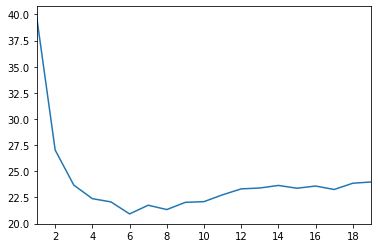

In [13]:
def get_cv_error(k):
  pipeline_k = make_pipeline(
      ct_2,
      KNeighborsRegressor(n_neighbors=k)
  )
  cv_errs = -cross_val_score(pipeline_k, X=X_train_2, y=y_train,
                             scoring="neg_mean_squared_error",
                             cv=10)
  return cv_errs.mean()

ks = pd.Series(range(1,20))
ks.index = range(1,20)
test_errs = ks.apply(get_cv_error)
test_errs.plot.line()
test_errs.sort_values()

**THIRD MODEL:** The mean squared error is minimized at 6, so we will now use 6 neighbors as our model.

In [0]:
X_train_3 = df_train[["pts", "reb", "ast", "blk", "stl", "player_position"]]
y_train = df_train["height (cm)"]
X_test_3 = df_test[["pts", "reb", "ast", "blk", "stl", "player_position"]]

ct_3 = make_column_transformer(
    (StandardScaler(), ["pts", "reb", "ast", "blk", "stl"]),
    (OneHotEncoder(handle_unknown='ignore'), ["player_position"]),
    remainder='drop'
)
pipeline_3 = make_pipeline(
    ct_3,
    KNeighborsRegressor(n_neighbors=6)
)

pipeline_3.fit(X=X_train_3,
               y=y_train)
prediction3 = pipeline_3.predict(X_test_3)

In [15]:
np.sqrt(mean_squared_error(prediction3, actual_heights))

3.882134422810181

We are now even more accurate with our model!

**MODEL 4:** Lastly, let's get the most optimal set of features for the K-Nearest Neighbors model.

In [16]:
def get_cv_error_features(features):
  pipeline = make_pipeline(
      StandardScaler(),
      KNeighborsRegressor(n_neighbors=6)
  )
  cv_errs = -cross_val_score(pipeline, X=df_train[features],
                             y=y_train,
                             scoring="neg_mean_squared_error",
                             cv=10)
  return cv_errs.mean()

errs = pd.Series()
features_list = [["reb", "blk", "fg_pct"],
                 ["pts", "reb", "ast", "blk", "stl"],
                 ["pts", "reb", "ast", "blk", "stl", "fg_pct"],
                 ["pts", "reb", "ast", "blk", "stl", "minutes/gm"],
                 ["pts", "reb", "ast", "blk", "stl", "player_weight"],
                 ["pts", "reb", "ast", "blk", "stl", "pf"],
                 ["pts", "reb", "ast", "blk", "stl", "pf", "fg_pct"],
                 ["pts", "reb", "ast", "blk", "stl", "pf", "player_weight"],
                 ["pts", "reb", "ast", "blk", "stl", "player_weight"],
                 ["pts", "reb", "ast", "blk", "stl", "pf", "player_weight", "fg_pct"],
                 ["pts", "reb", "ast", "blk", "stl", "player_weight", "fg_pct", "minutes/gm"]]
for features in features_list:
  errs[str(features)] = get_cv_error_features(features)
errs

['reb', 'blk', 'fg_pct']                                                        49.884120
['pts', 'reb', 'ast', 'blk', 'stl']                                             29.993432
['pts', 'reb', 'ast', 'blk', 'stl', 'fg_pct']                                   29.816484
['pts', 'reb', 'ast', 'blk', 'stl', 'minutes/gm']                               30.802994
['pts', 'reb', 'ast', 'blk', 'stl', 'player_weight']                            22.676478
['pts', 'reb', 'ast', 'blk', 'stl', 'pf']                                       35.110852
['pts', 'reb', 'ast', 'blk', 'stl', 'pf', 'fg_pct']                             31.301154
['pts', 'reb', 'ast', 'blk', 'stl', 'pf', 'player_weight']                      23.314988
['pts', 'reb', 'ast', 'blk', 'stl', 'pf', 'player_weight', 'fg_pct']            24.357997
['pts', 'reb', 'ast', 'blk', 'stl', 'player_weight', 'fg_pct', 'minutes/gm']    23.310555
dtype: float64

It seems that the best model was the one that used pts, reb, ast, blk, stl, and player_weight as the features. We will now train a stronger Linear Regression Model using these features.

In [0]:
X_train_4 = df_train[["pts", "reb", "ast", "blk", "stl", "player_weight"]]
y_train = df_train["height (cm)"]
X_test_4 = df_test[["pts", "reb", "ast", "blk", "stl", "player_weight"]]

ct_4 = make_column_transformer(
    (StandardScaler(), ["pts", "reb", "ast", "blk", "stl", "player_weight"]),
    remainder='drop'
)
pipeline_4 = make_pipeline(
    ct_4,
    LinearRegression()
)

pipeline_4.fit(X=X_train_4,
               y=y_train)
prediction4 = pipeline_4.predict(X_test_4)

In [18]:
np.sqrt(mean_squared_error(prediction4, actual_heights))

4.877091190256266

In [19]:
df_results = pd.DataFrame()
df_results["Player"] = df_test["player_name"]
df_results["Predicted Height (cm)"] = prediction4
df_results["Actual Height (cm)"] = actual_heights
df_results["Difference"] = np.abs(df_results["Predicted Height (cm)"] - df_results["Actual Height (cm)"])
df_results

,Player,Predicted Height (cm),Actual Height (cm),Difference
28,Michael Carter-Williams,193.718595,195.58,1.861405
47,Wayne Ellington,194.536415,193.04,1.496415
104,Enes Kanter,214.561853,208.28,6.281853
126,Wesley Matthews,198.825386,193.04,5.785386
131,Jodie Meeks,198.668978,193.04,5.628978
137,Greg Monroe,211.932503,210.82,1.112503
139,Markieff Morris,207.238376,203.00,4.238376
204,Andrew Bogut,212.747895,213.36,0.612105
205,Donatas Motiejunas,202.262654,213.36,11.097346
206,Eric Moreland,206.056816,208.28,2.223184


**FINAL MODEL:** Adding player weight did not seem to narrow down our error any further when combined with our current best model. In addition, we don't want to use player weight in the model anyway because it is not an NBA statistic; a game's outcome will usually not be dependant solely on the weight of the players. So, we will use model 3, using K-Nearest Neighbors, as our final model. Let's see how the predicted heights compared to the actual heights, side to side.

In [0]:
X_train_3 = df_train[["pts", "reb", "ast", "blk", "stl", "player_position"]]
y_train = df_train["height (cm)"]
X_test_3 = df_test[["pts", "reb", "ast", "blk", "stl", "player_position"]]

ct_3 = make_column_transformer(
    (StandardScaler(), ["pts", "reb", "ast", "blk", "stl"]),
    (OneHotEncoder(handle_unknown='ignore'), ["player_position"]),
    remainder='drop'
)
pipeline_3 = make_pipeline(
    ct_3,
    KNeighborsRegressor(n_neighbors=6)
)

pipeline_3.fit(X=X_train_3,
               y=y_train)
prediction3 = pipeline_3.predict(X_test_3)

In [21]:
df_results = pd.DataFrame()
df_results["Player"] = df_test["player_name"]
df_results["Predicted Height (cm)"] = prediction3
df_results["Actual Height (cm)"] = actual_heights
df_results["Difference"] = np.abs(df_results["Predicted Height (cm)"] - df_results["Actual Height (cm)"])
df_results

,Player,Predicted Height (cm),Actual Height (cm),Difference
28,Michael Carter-Williams,193.886667,195.58,1.693333
47,Wayne Ellington,196.003333,193.04,2.963333
104,Enes Kanter,209.126667,208.28,0.846667
126,Wesley Matthews,198.966667,193.04,5.926667
131,Jodie Meeks,193.040000,193.04,0.000000
137,Greg Monroe,208.703333,210.82,2.116667
139,Markieff Morris,204.470000,203.00,1.470000
204,Andrew Bogut,207.010000,213.36,6.350000
205,Donatas Motiejunas,206.163333,213.36,7.196667
206,Eric Moreland,207.010000,208.28,1.270000


In [22]:
df_results["Difference"].sum(), df_results["Difference"].mean()

(34.06666666666672, 3.0969696969697016)

In [23]:
df_avgs["height (cm)"].max() - df_avgs["height (cm)"].min(), df_avgs["height (cm)"].std()

(38.099999999999994, 8.433337781251472)

We see that our K-Nearest Neighbors model had a mean test error of 3.10 centimeters. Compared to the range and standard deviation of the data shown above, this is a fairly decent test error.

**RANDOM FORESTS REGRESSOR:** We also created a Random Forests model for the data. We found that although it had a lower training error for some runtimes, it produced a greater mean testing error than the K-Nearest Neighbors model for all the runtimes. Therefore, the previous K-Nearest Neighbors model is listed as our final model.

In [24]:
from sklearn.ensemble import RandomForestRegressor

df_rf = pd.DataFrame()

ct_5 = make_column_transformer(
    (StandardScaler(), ["pts", "reb", "ast", "blk", "stl"]),
    (OneHotEncoder(handle_unknown='ignore'), ["player_position"]),
    remainder='drop'
)

for k in range(1, 50):
  pipeline_5 = make_pipeline(
    ct_5,
    RandomForestRegressor(n_estimators=k)
    )
  cv_errs = -cross_val_score(pipeline_5,
                             X=df_train[["pts", "reb", "ast", "blk", "stl", "player_position"]],
                             y=df_train["height (cm)"],
                             scoring="neg_mean_squared_error",
                             cv=10)
  df_rf.loc[k, "RMSE"] = np.sqrt(cv_errs.mean())

df_rf.head()

,RMSE
1,6.205993
2,5.206266
3,5.139494
4,4.910257
5,4.689492


29    4.325969
42    4.337505
48    4.342305
41    4.343704
33    4.359741
Name: RMSE, dtype: float64

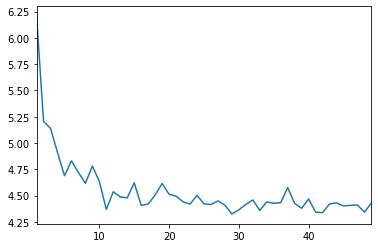

In [25]:
df_rf["RMSE"].plot.line()
df_rf["RMSE"].sort_values().head()

In [0]:
X_train_5 = df_train[["pts", "reb", "ast", "blk", "stl", "player_position"]]
y_train = df_train["height (cm)"]
X_test_5 = df_test[["pts", "reb", "ast", "blk", "stl", "player_position"]]

ct_5 = make_column_transformer(
    (StandardScaler(), ["pts", "reb", "ast", "blk", "stl"]),
    (OneHotEncoder(handle_unknown='ignore'), ["player_position"]),
    remainder='drop'
)
pipeline_5 = make_pipeline(
    ct_5,
    RandomForestRegressor(n_estimators=29)
)

pipeline_5.fit(X=X_train_5,
               y=y_train)
prediction5 = pipeline_5.predict(X_test_5)

In [35]:
df_results = pd.DataFrame()
df_results["Player"] = df_test["player_name"]
df_results["Predicted Height (cm)"] = prediction5
df_results["Actual Height (cm)"] = actual_heights
df_results["Difference"] = np.abs(df_results["Predicted Height (cm)"] - df_results["Actual Height (cm)"])
df_results

,Player,Predicted Height (cm),Actual Height (cm),Difference
28,Michael Carter-Williams,193.040000,195.58,2.540000
47,Wayne Ellington,197.769655,193.04,4.729655
104,Enes Kanter,210.907586,208.28,2.627586
126,Wesley Matthews,198.733103,193.04,5.693103
131,Jodie Meeks,195.580000,193.04,2.540000
137,Greg Monroe,208.980690,210.82,1.839310
139,Markieff Morris,203.462759,203.00,0.462759
204,Andrew Bogut,207.228966,213.36,6.131034
205,Donatas Motiejunas,211.433103,213.36,1.926897
206,Eric Moreland,205.126897,208.28,3.153103


In [36]:
df_results["Difference"].sum(), df_results["Difference"].mean()

(35.58482758620676, 3.2349843260187963)

In [37]:
df_avgs["height (cm)"].max() - df_avgs["height (cm)"].min(), df_avgs["height (cm)"].std()

(38.099999999999994, 8.433337781251472)

In [0]:
#from google.colab import drive
#drive.mount('drive')

In [0]:
#df_results.to_csv("linearresults.csv")
#!cp linearresults.csv "drive/My Drive/"

In [0]:
# df_test.to_csv("testdata.csv")
# !cp testdata.csv "drive/My Drive/"

**BEST LINEAR REGRESSION MODEL:** Trained on points, rebounds, assists, blocks, steals, and player weight to predict the player's height. The smallest RMSE was 4.877.

**BEST K NEAREST NEIGHBORS MODEL:** Trained on points, rebounds, blocks, assists, steals, and position with the nearest 6 neighbors. The smallest RMSE was 3.882.

**BEST RANDOM FOREST MODEL:** Trained on points, rebounds, blocks, assists, steals, and position with the 37 estimators. The smallest RMSE was 3.282 (during one runtime session; this might change when rerunning the code).

**CONCLUSION AND FINAL ANALYSIS**: Using statistics of a player's points, rebounds, assists, blocks, steals, and position, our K-Nearest Neighbors model predicted 8 out of 11 players' heights within 4.5 centimeters of error, with a final mean test error of 3.10 centimeters. After tuning the best value for k (6 neighbors) and the best features to account for, we found that the the biggest factor to an accurate model are points, rebounds, blocks, assists, steals, and the player's position created the most accurate model. This makes sense, as taller players are usually forwards or centers, and tend to grab more rebounds, block more shots and score more points, at the cost of having less assists and steals. Overall, our model provides great insight on the correlation between a player's performance playing basketball and their height.